In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
image_size = (72, 72)
input_shape = (72, 72, 3)

# Use image_dataset_from_directory to easily acquire images and their labels.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'spots/LASt-aug',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=1,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'spots/LASt-aug',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=1,
    label_mode='categorical'
)

Found 5726 files belonging to 5 classes.
Using 4581 files for training.
Found 5726 files belonging to 5 classes.
Using 1145 files for validation.


In [3]:
# Training data
X_train, y_train = [], []
for image, label in train_ds:
    X_train.append(image)
    y_train.append(np.array(label))
X_train = np.array(X_train, dtype=np.uint8)
X_train = X_train.reshape((X_train.shape[0],) + input_shape)
y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0],) + (y_train.shape[-1],))

# Validation data
X_val, y_val = [], []
for image, label in val_ds:
    X_val.append(image)
    y_val.append(np.array(label))
X_val = np.array(X_val, dtype=np.uint8)
X_val= X_val.reshape((X_val.shape[0],) + input_shape)
y_val = np.array(y_val)
y_val = y_val.reshape((y_val.shape[0],) + (y_val.shape[-1],))

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (4581, 72, 72, 3)
y_train shape: (4581, 5)
X_val shape: (1145, 72, 72, 3)
y_val shape: (1145, 5)


C:\Users\WELCOME\Anaconda3\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


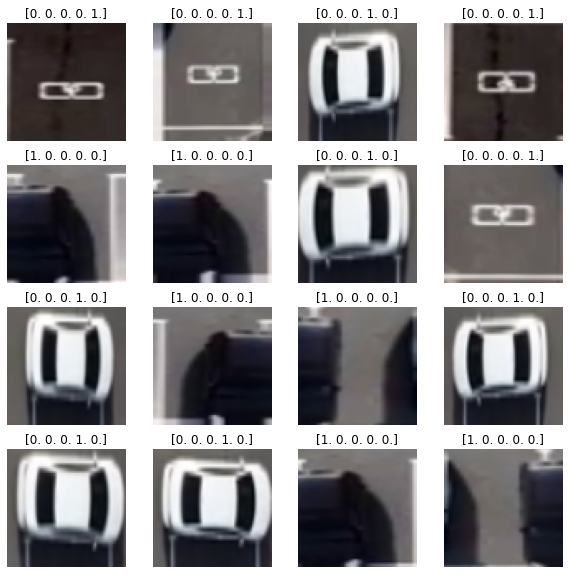

In [4]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for image, label, ax in zip(X_train, y_train, axes.flatten()):
    ax.imshow(image)
    ax.set_title(label)
    ax.set_axis_off()
plt.savefig('sample_training_data.png')

In [5]:
def load_pretrained_models(input_shape):
    """Load all the pre-trained models that we want to try.

    We can add any pre-trained models provided by keras here. We return
    a dict that contains the model itself and the `preprocess_input`
    function associated with each model.

    :param input_shape: Shape of the input image.
    :return: A dict containing each pre-trained model and its pre-process
        function.
    """
    all_models = {
        'xception': {
            'model': keras.applications.Xception(include_top=False, input_shape=input_shape),
            'preprocess': keras.applications.xception.preprocess_input,
        },
        'vgg16': {
            'model': keras.applications.VGG16(include_top=False, input_shape=input_shape),
            'preprocess': keras.applications.vgg16.preprocess_input,
        },
        'resnet50': {
            'model': keras.applications.ResNet50(include_top=False, input_shape=input_shape),
            'preprocess': keras.applications.resnet.preprocess_input,
        },
    }
    return all_models


all_models = load_pretrained_models(input_shape)

In [6]:
def make_model(input_shape, num_classes):
    """Make our own model.

    Note that since we are using a pre-trained model to extract features
    for us, the input is no longer the image itself, but the extracted
    feature from the pre-trained model. The model itself is very simple.
    Since the features have been extracted alredy, we only need to attach
    a flatten and dense layer to complete the network.

    :param input_shape: The shape of the OUTPUT of the pre-trained model.
    :param num_classes: The number of classes to predict.
    :return: The instance of our own model
    """
    inputs = keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    outputs = layers.Dense(
        num_classes,
        activation='softmax' if num_classes > 1 else 'sigmoid',
    )(x)

    model = keras.Model(inputs, outputs)
    return model

In [7]:
def fit_model(all_models, model_name, X_train, y_train, X_val, y_val, num_classes=5, batch_size=32):
    """The one-stop shop to fit the model.

    It goes from pre-processing the data, extract features from the data using a pre-trained
    model, feed the extracted features to our own model, fit the model, and obtain results.

    :param all_models: A dict containing all the models and their pre-processing functions.
    :param model_name: Name of the model. Available names are the keys of `all_models`.
    :param X_train: training images, as a numpy array of shape (n, width, height, channel),
        where n is the number of training images.
    :param y_train: Training labels, as a numpy array of shape (n, k), where n is the number
        of training images and k the number of classes to predict (same as `num_classes`).
        Note that the labels are one-hot encoded.
    :param X_val: validation images, as a numpy array of shape (m, width, height, channel),
        where m is the number of validation images.
    :param y_val: validation labels, as a numpy array of shape (m, k), where m is the number
        of validation images. The meaning of k is the same as described in `y_train`.
    :param num_classes: Number of classes to predict. Default to 3.
    :param batch_size: Default to 32.
    """
    premodel = all_models[model_name]['model']
    preprocess = all_models[model_name]['preprocess']
    # use the output shape of the premodel as the input shape of our own model
    model = make_model(premodel.output.shape[1:], num_classes)
    # Create new training data
    X_train_pretrained = premodel.predict(preprocess(X_train))
    train_ds_pretrained = tf.data.Dataset.from_tensor_slices(
        (X_train_pretrained, y_train),
    ).batch(batch_size)
    # Create new validation data
    X_val_pretrained = premodel.predict(preprocess(X_val))
    val_ds_pretrained = tf.data.Dataset.from_tensor_slices(
        (X_val_pretrained, y_val),
    ).batch(batch_size)
    # fit model
    epochs = 50
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    history = model.fit(
        train_ds_pretrained,
        epochs=epochs,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=10, verbose=1, mode='auto')
        ],
        validation_data=val_ds_pretrained,
    )
    return model, history

In [8]:
def plot_loss_acc(history, file_name=''):
    """Plot the loss and accuracy of a model fitting process.

    :param history: Returned history from model fitting. It must be a dict that
        contains the keys for 'loss', 'accuracy', 'val_loss', and 'val_accuracy'.
    :param file_name: file name (and path) to save the figure.
    """
    SMALL_SIZE = 10
    MEDIUM_SIZE = 20
    LARGE_SIZE = 30

    # plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=LARGE_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    epochs = np.arange(1, len(history['loss']) + 1)
    
    ax1.plot(epochs, history['loss'], label='Train')
    ax1.plot(epochs, history['val_loss'], label='Validate')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('(A) Model Loss Across Epochs')
    ax1.legend(loc="upper right")

    ax2.plot(epochs, history['accuracy'], label='Train')
    ax2.plot(epochs, history['val_accuracy'], label='Validate')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('(B) Model Accuracy Across Epochs')
    ax2.legend(loc="upper left")
    plt.tight_layout()
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

In [9]:
model_xception, history_xception = fit_model(all_models, 'xception', X_train, y_train, X_val, y_val)

Epoch 1/50
144/144 [==============================] - 5s 17ms/step - loss: 0.0590 - accuracy: 0.9856 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 2/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 3/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 4/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 5/50
144/144 [==============================] - 2s 13ms/step - loss: 8.7539e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 6/50
144/144 [==============================] - 2s 11ms/step - loss: 6.9004e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/50
144/144 [==============================] - 2s 11ms/step - loss: 5.5785e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accu

In [10]:
model_vgg16, history_vgg16 = fit_model(all_models, 'vgg16', X_train, y_train, X_val, y_val)

Epoch 1/50
144/144 [==============================] - 4s 14ms/step - loss: 0.2183 - accuracy: 0.9710 - val_loss: 0.0024 - val_accuracy: 0.9991
Epoch 2/50
144/144 [==============================] - 1s 7ms/step - loss: 7.3100e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 3/50
144/144 [==============================] - 1s 7ms/step - loss: 4.7685e-05 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/50
144/144 [==============================] - 1s 7ms/step - loss: 3.5090e-05 - accuracy: 1.0000 - val_loss: 8.1294e-04 - val_accuracy: 1.0000
Epoch 5/50
144/144 [==============================] - 1s 7ms/step - loss: 2.7201e-05 - accuracy: 1.0000 - val_loss: 6.2501e-04 - val_accuracy: 1.0000
Epoch 6/50
144/144 [==============================] - 1s 7ms/step - loss: 2.1799e-05 - accuracy: 1.0000 - val_loss: 4.9262e-04 - val_accuracy: 1.0000
Epoch 7/50
144/144 [==============================] - 1s 7ms/step - loss: 1.7889e-05 - accuracy: 1.0000 - val_loss:

In [11]:
model_resnet50, history_resnet50 = fit_model(all_models, 'resnet50', X_train, y_train, X_val, y_val)

Epoch 1/50
144/144 [==============================] - 4s 18ms/step - loss: 0.0371 - accuracy: 0.9891 - val_loss: 1.1164e-04 - val_accuracy: 1.0000
Epoch 2/50
144/144 [==============================] - 2s 11ms/step - loss: 9.3992e-06 - accuracy: 1.0000 - val_loss: 7.0804e-05 - val_accuracy: 1.0000
Epoch 3/50
144/144 [==============================] - 2s 12ms/step - loss: 1.3222e-06 - accuracy: 1.0000 - val_loss: 6.0600e-05 - val_accuracy: 1.0000
Epoch 4/50
144/144 [==============================] - 2s 11ms/step - loss: 9.2326e-07 - accuracy: 1.0000 - val_loss: 5.2575e-05 - val_accuracy: 1.0000
Epoch 5/50
144/144 [==============================] - 2s 11ms/step - loss: 6.9361e-07 - accuracy: 1.0000 - val_loss: 4.6158e-05 - val_accuracy: 1.0000
Epoch 6/50
144/144 [==============================] - 2s 11ms/step - loss: 5.4512e-07 - accuracy: 1.0000 - val_loss: 4.0937e-05 - val_accuracy: 1.0000
Epoch 7/50
144/144 [==============================] - 2s 11ms/step - loss: 4.4216e-07 - accuracy: 

In [12]:
model_resnet50.save('spot_parked_detection_model-FPLAST33')

INFO:tensorflow:Assets written to: spot_parked_detection_model-FPLAST33\assets


In [13]:
model_xception.save('spot_parked_detection_model-XCLAST33')

INFO:tensorflow:Assets written to: spot_parked_detection_model-XC\assets


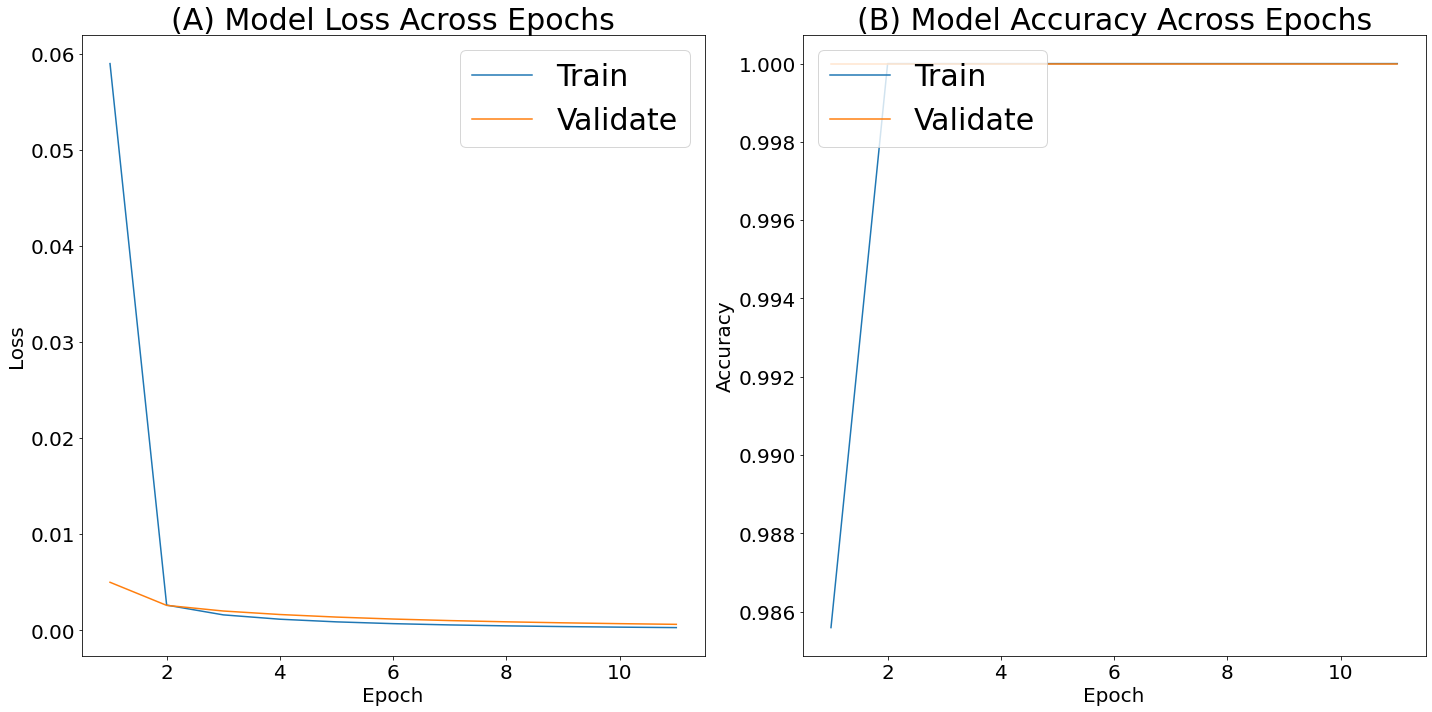

In [13]:
plot_loss_acc(history_xception.history, 'xception_loss_acc.png')

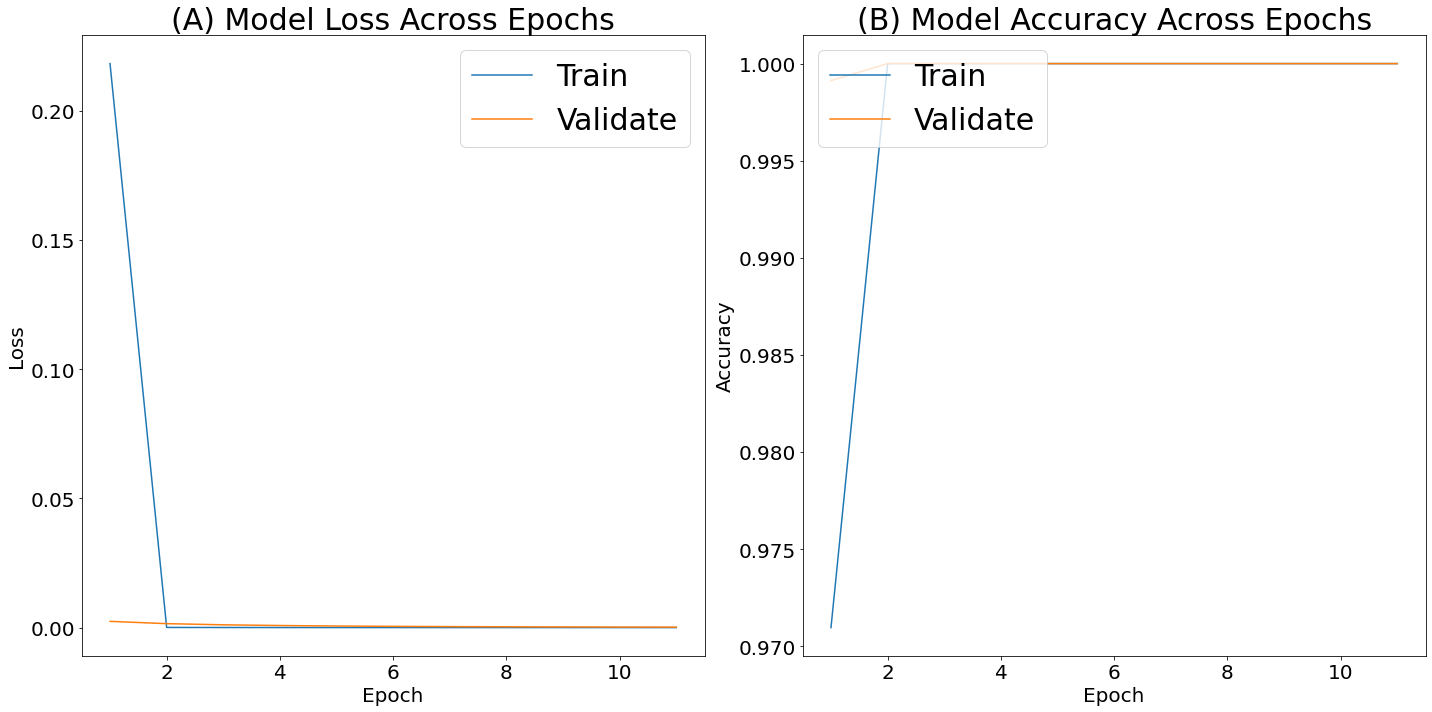

In [14]:
plot_loss_acc(history_vgg16.history, 'vgg16_loss_acc.png')

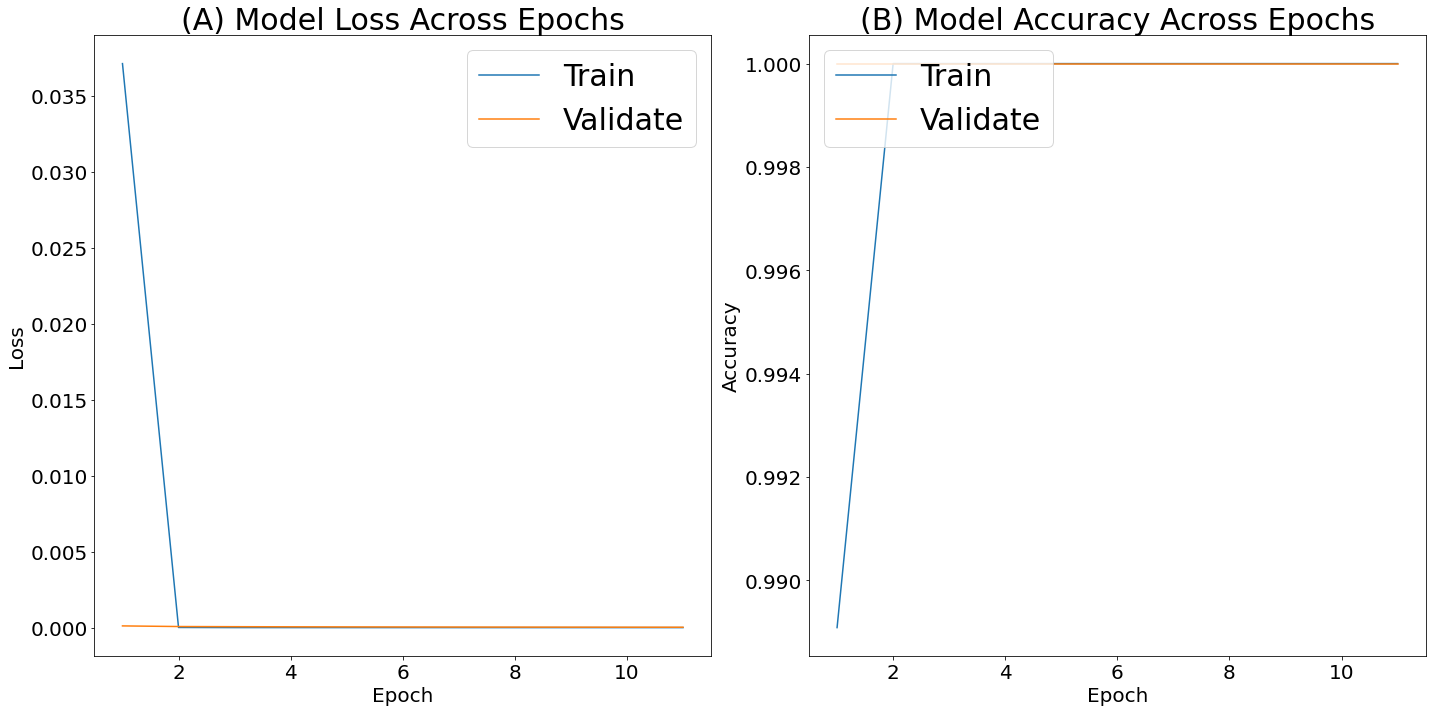

In [15]:
plot_loss_acc(history_resnet50.history, 'resnet50_loss_acc.png')